In [1]:
import time
import logging
from IPython.display import Audio

from IDRnD.utils import *
from IDRnD.augmentations import *
from IDRnD.dataset import *
from IDRnD.resnet import resnet50
from IDRnD.focalloss import FocalLoss

import numpy as np
import torch
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CyclicLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

from sklearn.model_selection import StratifiedKFold, train_test_split

%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed_everything(0)
logging.basicConfig(level=logging.DEBUG, filename="logs/logs.log",
                    filemode="w+")

In [2]:
X, y = get_train_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
post_transform = transforms.Compose([
    librosa.power_to_db,
    PadOrClip(150),
    Normalize_predef(-29.6179, 16.6342),
    #Normalize(),
    ToTensor(),
    #transforms.ToTensor(),
])

In [4]:
##train
batch_size = 400
hm = Train(model_path="models/resnet_50.pt", gradient_acumulation=[5, 10, 15, 20, 30, 40])

train_dataset = MelDataset(X_train, y_train, "../data/files/raw_mels", post_transform)
#train_dataset_mixmatch = Dataset_Train_Mixmatch(train_dataset, post_transform=post_transform, pad_lenth=256)
valid_dataset = MelDataset(X_val, y_val, "../data/files/raw_mels_val", post_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

#model = Classifier(1).cuda()
model = resnet50(num_classes=1).cuda()
#model.load_state_dict(torch.load('models/resnet_18_last_epoch.pt'))
#model_sig = torch.nn.Sequential(model, torch.sigmoid).cuda()
model_dst = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()

#criterion = nn.BCEWithLogitsLoss(weight=torch.Tensor([5])).cuda()
#criterion = torch.nn.BCEWithLogitsLoss().cuda()
criterion = FocalLoss(gamma=2, reduce='sum').cuda()
optimizer = Adam(params=model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, patience=7, verbose=True)

In [5]:
hm.fit(train_loader, valid_loader, model_dst, criterion, optimizer, scheduler, epoches=100)

/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch    64: reducing learning rate of group 0 to 1.0000e-05.
Epoch    83: reducing learning rate of group 0 to 1.0000e-06.
Epoch    93: reducing learning rate of group 0 to 1.0000e-07.


In [7]:
torch.save(model_dst.module.state_dict(), "models/resnet_18_last_epoch.pt")

In [8]:
mels = []
means = []
stds = []

for i in range(len(train_dataset)):
    tensor = train_dataset[i][0]
    mels.append(train_dataset[i][0])

In [32]:
lens = np.array([i.shape[2] for i in mels])

In [46]:
hm = pd.DataFrame(np.vstack((lens, y_train)).T)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bcb65c9e8>]],
      dtype=object)

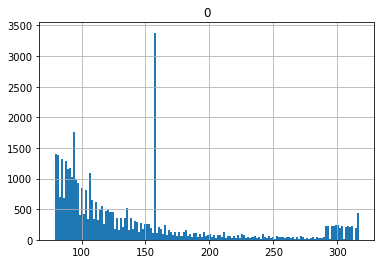

In [59]:
pd.DataFrame(hm[0]).hist(bins = 150)

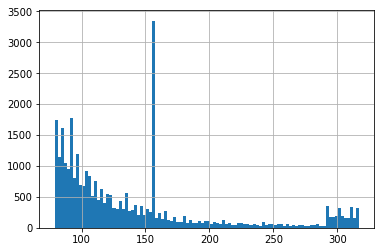

In [58]:
hm[hm[1] == 0][0].hist(bins=100)

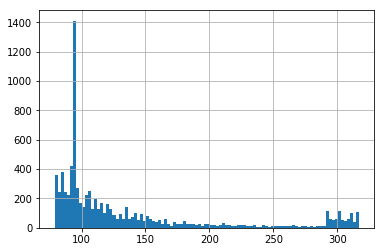

In [57]:
hm[hm[1] == 1][0].hist(bins=100)

In [38]:
pd.DataFrame(data = [lens, y_train])

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
0,83,93,106,94,85,161,126,119,134,299,...,88,80,132,91,98,94,88,83,101,109
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
